In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression

In [42]:
con = sqlite3.connect(r"../laliga.sqlite")
# Change date format (2029 -> 1929)
df = pd.read_sql_query("SELECT * FROM Matches", con)

# Data formatting:
# We split the "date" column into the corresponding columns, and specify the correct formatting.
# This way we avoid the year 29 or higher to be mistaken by 2029 (error with to_datetime function).
df[["month", "day", "year"]] = df["date"].str.split("/", 2, expand = True)
df["year"] = df["year"].apply(lambda x: f"19{x}" if int(x) >= 23 else f"20{x}")
df['date'] = pd.to_datetime(df[['day', 'month', 'year']]).dt.strftime('%d/%m/%Y') 

# We also change the formatting of the time to be in 24h format
df['time'] = df['time'].apply(lambda x: datetime.strftime(datetime.strptime(x, "%I:%M %p"), "%H:%M") if type(x) == str else x)

df[["home_goals", "away_goals"]] = df["score"].str.split(":", expand=True).astype(float)
df=df.dropna( subset=["score"])
df["goal diff"] = (df["home_goals"]  - df["away_goals"])
df["results"] = np.where(df["goal diff"] > 0, "1", np.where(df["goal diff"] < 0, "2", "X"))
df.head()

,season,division,matchday,date,time,home_team,away_team,score,month,day,year,home_goals,away_goals,goal diff,results
0,1928-1929,1,1,10/02/1929,None,Arenas Club,Athletic Madrid,2:3,2,10,1929,2.0,3.0,-1.0,2
1,1928-1929,1,1,10/02/1929,None,Espanyol,Real Unión,3:2,2,10,1929,3.0,2.0,1.0,1
2,1928-1929,1,1,10/02/1929,None,Real Madrid,Catalunya,5:0,2,10,1929,5.0,0.0,5.0,1
3,1928-1929,1,1,10/02/1929,None,Donostia,Athletic,1:1,2,10,1929,1.0,1.0,0.0,X
4,1928-1929,1,1,12/02/1929,None,Racing,Barcelona,0:2,2,12,1929,0.0,2.0,-2.0,2


In [43]:
home_team_dummies = pd.get_dummies(df.home_team)
away_team_dummies = pd.get_dummies(df.away_team)


In [44]:
teams = list(home_team_dummies.columns)
team_dict = {}
for i in teams:
    team_dict[i] = "H_"+ i
home_team_dummies = home_team_dummies.rename(columns=team_dict)
home_team_dummies

,H_AD Almería,H_Alavés,H_Albacete,H_Alcorcón,H_Algeciras CF,H_Alicante CF,H_Alzira,H_Arenas Club,H_Arosa SC,H_At. Madrileño,...,H_UD Vecindario,H_UE Figueres,H_UE Lleida,H_UP Langreo,H_Uni. Las Palmas,H_Valencia,H_Villarreal,H_Villarreal CF B,H_Xerez CD,H_Écija Balompié
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df = pd.concat([df, home_team_dummies], axis=1)
df = pd.concat([df, away_team_dummies], axis=1)
columns = list(df.columns)

In [46]:
season_2008 = df[df.season == "2008-2009"]
season_2009 = df[df.season == "2009-2010"]

In [47]:
x_train = df[df.season != "2009-2010"].drop(columns=['season',
 'date',
 'time',
 'home_team',
 'away_team',
 'score',
 'home_goals',
 'away_goals',
 'goal diff',
 'results'])
y_train = df[df.season != "2009-2010"].results

In [48]:
x_train

,division,matchday,month,day,year,H_AD Almería,H_Alavés,H_Albacete,H_Alcorcón,H_Algeciras CF,...,UD Vecindario,UE Figueres,UE Lleida,UP Langreo,Uni. Las Palmas,Valencia,Villarreal,Villarreal CF B,Xerez CD,Écija Balompié
0,1,1,2,10,1929,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,10,1929,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,2,10,1929,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,2,10,1929,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,2,12,1929,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48585,2,3,8,28,2021,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48586,2,3,8,29,2021,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48587,2,3,8,29,2021,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48588,2,3,8,29,2021,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [50]:
x_test = season_2009.drop(columns=['season',
 'date',
 'time',
 'home_team',
 'away_team',
 'score',
 'home_goals',
 'away_goals',
 'goal diff',
 'results'])
y_test = list(season_2009.results)

In [51]:
y_pred = model.predict(x_test)
model.score(x_test, y_test)

0.47030878859857483

In [52]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[396,   0,   0],
       [206,   0,   0],
       [240,   0,   0]], dtype=int64)

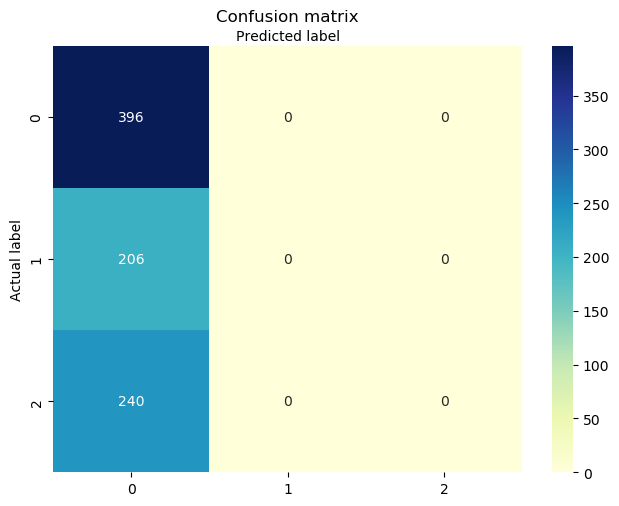

In [53]:
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.Text(0.5,257.44,'Predicted label');

In [61]:
coeficients  = pd.DataFrame({"Variable":x_train.columns, "Coefficient":model.coef_[0]})
coeficients

,Variable,Coefficient
0,division,-0.027804
1,matchday,-0.004395
2,month,-0.021812
3,day,-0.000305
4,year,0.000396
...,...,...
304,Valencia,-0.004112
305,Villarreal,-0.003600
306,Villarreal CF B,-0.000008
307,Xerez CD,-0.001005


In [60]:
coeficients.sort_values("Coefficient", ascending=False)

,Variable,Coefficient
115,H_Real Madrid,0.023109
28,H_Barcelona,0.022635
23,H_Atlético Madrid,0.010823
152,H_Valencia,0.010174
16,H_Athletic,0.008957
...,...,...
175,Atlético Madrid,-0.010871
180,Barcelona,-0.017880
267,Real Madrid,-0.021502
2,month,-0.021812
